In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from utils.topo_ds import *
import seaborn as sns 
from utils.pershom import pers2fn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, GradientAccumulationScheduler
from pl_modules.pl_roberta import LitRelRoberta

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error
from utils.sim_rel import compare_topo_models, topo_model
from functools import partial

from utils.export_multilingual_results import process_df
from utils.multilingual_amazon_anchors import MultilingualAmazonAnchors
from typing import *

from modules.stitching_module import StitchingModule

from datasets import load_dataset, ClassLabel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = Path("./data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = Path("./saved_models/rel_multi_topo")
CHECKPOINT_PATH_VANILLA = Path("./saved_models/rel_multi_vanilla")
RESULT_PATH = Path("./results/rel_multi_topo")
FIG_PATH =  Path("./Visualization")

PROJECT_ROOT = Path("./")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


# Data

In [3]:
fine_grained: bool = True
target_key: str = "class"
data_key: str = "content"
anchor_dataset_name: str = "amazon_translated"  
ALL_LANGS = ("en", "fr")
num_anchors: int = 768
train_perc: float = 0.01

In [4]:
def get_dataset(lang: str, split: str, perc: float, fine_grained: bool):
    pl.seed_everything(42)
    assert 0 < perc <= 1
    dataset = load_dataset("amazon_reviews_multi", lang)[split]

    if not fine_grained:
        dataset = dataset.filter(lambda sample: sample["stars"] != 3)

    # Select a random subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[: int(len(indices) * perc)]
    dataset = dataset.select(indices)

    def clean_sample(sample):
        title: str = sample["review_title"].strip('"').strip(".").strip()
        body: str = sample["review_body"].strip('"').strip(".").strip()

        if body.lower().startswith(title.lower()):
            title = ""

        if len(title) > 0 and title[-1].isalpha():
            title = f"{title}."

        sample["content"] = f"{title} {body}".lstrip(".").strip()
        if fine_grained:
            sample[target_key] = str(sample["stars"] - 1)
        else:
            sample[target_key] = sample["stars"] > 3
        return sample

    dataset = dataset.map(clean_sample)
    dataset = dataset.cast_column(
        target_key,
        ClassLabel(num_classes=5 if fine_grained else 2, names=list(map(str, range(5) if fine_grained else (0, 1)))),
    )

    return dataset

def _amazon_translated_get_samples(lang: str, sample_idxs):
    anchor_dataset = MultilingualAmazonAnchors(split="train", language=lang)
    anchors = []
    for anchor_idx in sample_idxs:
        anchor = anchor_dataset[anchor_idx]
        anchor[data_key] = anchor["data"]
        anchors.append(anchor)
    return anchors

In [5]:
train_datasets = {
    lang: get_dataset(lang=lang, split="train", perc=train_perc, fine_grained=fine_grained) for lang in ALL_LANGS
    }

test_datasets = {
    lang: get_dataset(lang=lang, split="test", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

val_datasets = {
    lang: get_dataset(lang=lang, split="validation", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

num_labels = len(np.unique(train_datasets["en"][target_key], return_counts=True)[0])
print("Num labels:", num_labels)

Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-487341c777fb67da.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8bc7c81168188181.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-edf29a5fb3c71a5c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-281ed3221a51f226.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8553f71d56c9ba4c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-6e7cd514f6470b46.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-b471ec6ce2ee1b83.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-32bdb5fdc88164f7.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e7ff0dc70b32da22.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-79bd585130ea3a97.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-c271de877e412081.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-0b8801113f92f388.arrow


Num labels: 5


In [6]:
assert len(set(frozenset(train_dataset.features.keys()) for train_dataset in train_datasets.values())) == 1
class2idx = train_datasets["en"].features[target_key].str2int

train_datasets["en"].features

{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'class': ClassLabel(names=['0', '1', '2', '3', '4'], id=None)}

Get pararel anchors

In [7]:
anchor_dataset2num_samples = 1000
anchor_dataset2first_anchors = [
        776,
        507,
        895,
        922,
        33,
        483,
        85,
        750,
        354,
        523,
        184,
        809,
        418,
        615,
        682,
        501,
        760,
        49,
        732,
        336,
    ]


assert num_anchors <= anchor_dataset2num_samples

pl.seed_everything(42)
anchor_idxs = list(range(anchor_dataset2num_samples))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

assert anchor_idxs[:20] == anchor_dataset2first_anchors  # better safe than sorry
lang2anchors = {
    lang: _amazon_translated_get_samples(lang=lang, sample_idxs=anchor_idxs) for lang in ALL_LANGS
}

Global seed set to 42


This is how we can handdle automatically the tokenizer

In [8]:
def collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []
    
    for x, y in batch:
        data.append(x)
        if cls:
            labels.append(y)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [9]:
def multi_draw_collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []    
    for x, y in batch:
        data += x 
        if cls:
            labels += [y]*len(x)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [10]:
lang2transformer_name = {
    "en": "roberta-base",
    "fr": "ClassCat/roberta-base-french",
    #"es": "PlanTL-GOB-ES/roberta-base-bne",
    #"ja": "nlp-waseda/roberta-base-japanese",
}
assert set(lang2transformer_name.keys()) == set(ALL_LANGS)

In [11]:
train_lang2dataloader = {}
test_lang2dataloader = {}
val_lang2dataloader = {}
anchors_lang2dataloader = {}

for lang in ALL_LANGS:
    transformer_name = lang2transformer_name[lang]
    print(transformer_name)
    lang_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    
    aux_train_ds = DictDataset(train_datasets[lang], data_key, target_key)    
    train_lang2dataloader[lang] = DataLoader(aux_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       pin_memory=True,
                                       #persistent_workers= True,
                                       batch_sampler=ClassAccumulationSampler(aux_train_ds,
                                                       batch_size=16,
                                                       drop_last=True,
                                                       accumulation=num_labels,
                                                       indv=True,
                                                       main_random=True
                                                      )
                                            )
                                  
    
    aux_test_ds = DictDataset(test_datasets[lang], data_key, target_key)
    ds_test_multi = IntraLabelMultiDraw(aux_test_ds, 16)
    test_lang2dataloader[lang] = (DataLoader(aux_test_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       ),
                                  DataLoader(ds_test_multi,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=1,
                                       pin_memory=True
                                       )
                                 )
    
    
    aux_val_ds = DictDataset(val_datasets[lang], data_key, target_key)
    
    
    val_lang2dataloader[lang] = DataLoader(aux_val_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       )
    
    aux_anc_ds = DictDataset(lang2anchors[lang], data_key, target_key)
     
    anchors_lang2dataloader[lang] = DataLoader(aux_anc_ds,
                                       num_workers=4,
                                       pin_memory=True,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=48,
                                       )

roberta-base
ClassCat/roberta-base-french


# Train

In [12]:
from pl_modules.pl_topo_roberta import LitTopoRelRoberta

In [13]:
def test_model(model, dataloader, title=""):
    preds = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for batch, _ in tqdm(dataloader, position=0, leave=True, desc="Computing"+title):
            batch.to(device)
            batch_latents = model(batch_idx=batch_idx, **batch)["prediction"].argmax(-1)
            preds.append(batch_latents)
            batch_idx = 1

    preds = torch.cat(preds, dim=0).detach().cpu().numpy()
    test_y = np.array(test_datasets["en"][target_key])

    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, preds, average="weighted")
    mae = mean_absolute_error(y_true=test_y, y_pred=preds)
    acc = (preds == test_y).mean()
    return precision, recall, acc, fscore, mae

In [14]:
torch.autograd.set_detect_anomaly(True)

EPOCHS = 40 if fine_grained else 3


def train_network(lang, mode="relative", seed=24, test=False, topo=("pre", "L_2", 7, 0.1, "L_1")):
    
    # Create a PyTorch Lightning trainer with the generation callback
    aux = 'fine_grained' if fine_grained else 'coarse_grained'
    if topo is None:
        aux = f"{aux}/vanilla_linear_{lang}_{mode}_seed{seed}"
    else:
        aux = f"{aux}/topo_linear_{lang}_{mode}_seed{seed}"
        
    title = CHECKPOINT_PATH /  aux
    trainer = pl.Trainer(default_root_dir=title, 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         gradient_clip_val=1,
                         accumulate_grad_batches=num_labels+1,
                         max_epochs=EPOCHS, 
                         reload_dataloaders_every_n_epochs=1,
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                                   mode="max", monitor="val_acc",
                                                   filename="best"
                                                   ),
                                    ModelCheckpoint(save_weights_only=True,
                                                    filename="full"
                                                   ),
                                    LearningRateMonitor(logging_interval='step'),
                                    ]
                         )
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    transformer_model = lang2transformer_name[lang]
    
    anchor_loader = None
    if mode == "relative":
        anchor_loader = anchors_lang2dataloader[lang]
    
    train_loader = train_lang2dataloader[lang]
    steps = EPOCHS*len(train_loader)
    power = 10
    freq_anchors = power*(num_labels+1)
    model = LitTopoRelRoberta(
                          num_labels=num_labels,
                          transformer_model=transformer_model,
                          anchor_dataloader=anchor_loader,
                          topo_par=topo,
                          hidden_size=num_anchors,
                          normalization_mode="batchnorm",
                          output_normalization_mode=None,
                          dropout_prob=0.1,
                          seed=seed,
                          steps=steps,
                          weight_decay=0.01, 
                          head_lr=1e-3/(num_labels),
                          encoder_lr=1.75e-4/(num_labels),
                          layer_decay=0.65,
                          scheduler_act=True,
                          freq_anchors=freq_anchors,
                          device=device,
                          fine_tune=False,
                          linear=True
                          )
    
    val_loader = val_lang2dataloader[lang]
    trainer.fit(model, train_lang2dataloader[lang], val_dataloaders=val_loader)
    
    if test:
        
        res = test_model(model.net, test_lang2dataloader[lang][0])
        with open("res.txt", "a") as f:
            f.write(f"-------------{topo}-------------\n")
            f.write(f"precision {res[0]}\n")
            f.write(f"recall {res[1]}\n")
            f.write(f"acc {res[2]}\n")
            f.write(f"fscore {res[3]}\n")
            f.write(f"mae {res[4]}\n")
            
        print("precision", res[0])
        print("recall", res[1])
        print("acc", res[2])
        print("fscore", res[3])
        print("mae", res[4])
        aux = "rel_topo" if topo is not None else "rel_vanilla"
        
        topo_model(model.net, device, test_lang2dataloader[lang][1],
                 FIG_PATH / aux /
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/full_topo_dist_linear_{lang}_{mode}_seed{seed}.png",
                 title=f"{lang.upper()} {mode}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=mode=="relative");
       
    
    model.to("cpu")
    del model
    

In [15]:
train_network("en", mode="relative", seed=0, test=True, topo=None)
train_network("fr", mode="relative", seed=0, test=True, topo=None)
train_network("en", mode="relative", seed=1, test=True, topo=None)
train_network("fr", mode="relative", seed=1, test=True, topo=None)

embedding_type:   0%|                                                                    | 0/1 [00:00<?, ?it/s]

lang:   0%|                                                                              | 0/2 [00:00<?, ?it/s]Global seed set to 1
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

RelRoberta(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:43<00:00, 22.40it/s]


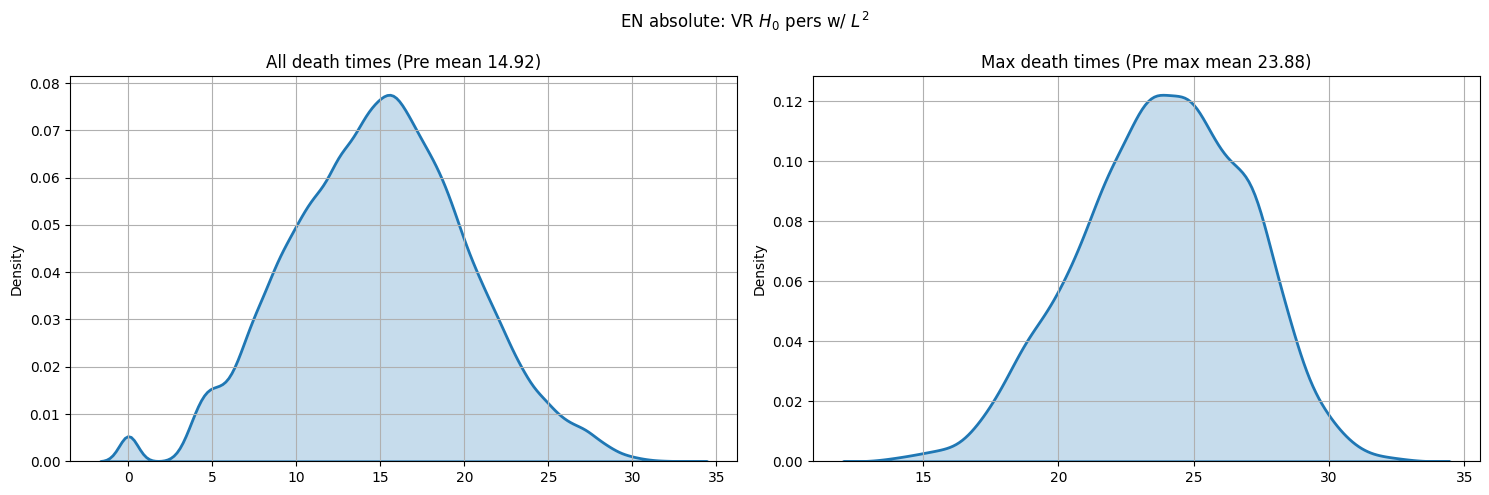



lang:  50%|██████████████████████████████████▌                                  | 1/2 [03:48<03:48, 228.41s/it]Global seed set to 1
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RelRoberta(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:16<00:00, 25.41it/s]


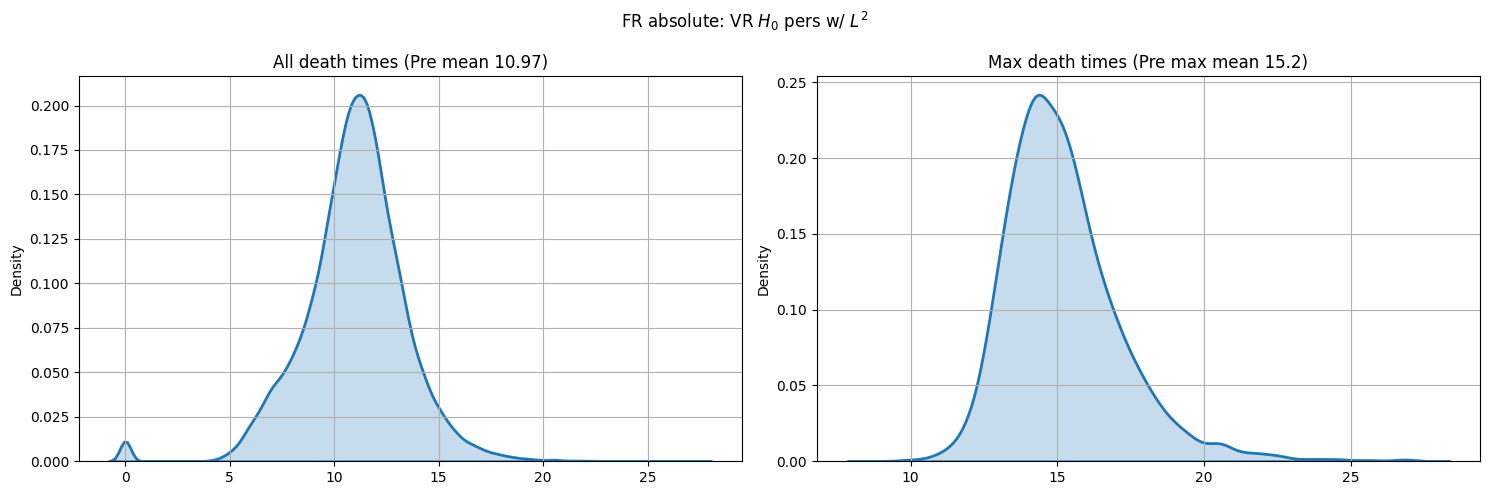



lang: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [07:10<00:00, 212.80s/it]

                                                                                                               
embedding_type: 100%|███████████████████████████████████████████████████████████| 1/1 [07:10<00:00, 430.29s/it]


In [18]:
SEEDS = [0, 1]
run = True

if run:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
            for mode in ["vanilla"]:
                for train_lang in tqdm(["en", "fr"], leave=False, desc="lang"):
                    model = LitTopoRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{mode}_linear_{train_lang}_{embedding_type}_seed{seed}" /
                                  "lightning_logs/version_0/checkpoints/best.ckpt",
                                   linear=True)
                    
                    model = model.net
                    print(model)
                    is_rel = embedding_type=="relative"
                    if is_rel:
                        model.anchor_dataloader = anchors_lang2dataloader[train_lang]

                 
                    res = test_model(model, test_lang2dataloader[train_lang][0])
                    with open("res.txt", "a") as f:
                        f.write(f"-------------###-------------\n")

                        f.write(f"precision {res[0]}\n")
                        f.write(f"recall {res[1]}\n")
                        f.write(f"acc {res[2]}\n")
                        f.write(f"fscore {res[3]}\n")
                        f.write(f"mae {res[4]}\n")


                    print("precision", res[0])
                    print("recall", res[1])
                    print("acc", res[2])
                    print("fscore", res[3])
                    print("mae", res[4])

                    topo_model(model, device, test_lang2dataloader[train_lang][1],
                     FIG_PATH / f"rel_{mode}"/
                     f"{'fine_grained' if fine_grained else 'coarse_grained'}/best_full_topo_dist_linear_{train_lang}_{embedding_type}_seed{seed}.png",
                     title=f"{train_lang.upper()} {embedding_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                     pers="L_2", plot_topo=True, relative=is_rel);
                


In [ ]:
SEEDS = [0]
TRAIN = False

if TRAIN:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for fine_tune in tqdm([False], leave=False, desc="fine_tune"):
            for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
                for train_lang in tqdm(ALL_LANGS, leave=False, desc="lang"):
                    train_network(train_lang, mode=embedding_type, seed=seed, fine_tune=fine_tune)
                    clear_output(wait=True)


# Results

## Compute

In [ ]:
numeric_results = {
    "vanilla": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": [],
        "CKA_pre":[],
        "CKA_post":[],
    },
     "topo": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": [],
        "CKA_pre":[],
        "CKA_post":[],
    },
}

pers = "L_2"
langs= ["en", "fr"]
embeddings = ["absolute"]
modes = ["vanilla"]

pers = "L_2"
langs= ["en", "fr"]
embeddings = ["absolute", "relative"]
                      

for seed in [0]:
    models = {
        train_mode: {
            embedding_type: {
                    train_lang: LitRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_mode}_linear_{train_lang}_{embedding_type}_seed{seed}" /
                                  "lightning_logs/version_0/checkpoints/full-v1.ckpt",
                                   linear=linear)
                    

                    for train_lang in langs
                }
                for embedding_type in embeddings
        }
        for train_mode in tqdm(modes, leave=True, desc="mode")
    }
    
    for mode in modes:
        for k, embed_type in enumerate(embeddings):
            for i, enc_lang  in enumerate(langs):
                for j, dec_lang  in enumerate(langs):
                    
                    model_enc = models[mode][embed_type][enc_lang].net
                    relative = embed_type == "relative"
                    if relative:
                        model_enc.anchor_dataloader = anchors_lang2dataloader[enc_lang]
                    
                    if enc_lang != dec_lang:
                        model_dec = models[mode][embed_type][dec_lang].net
                        model = StitchingModule(model_enc, model_dec)
                    else:
                        model = model_enc
                      
                        
                    # The data is paired with its encoder
                    test_loader = test_lang2dataloader[enc_lang][0]
                    title = f" {mode}_seed{seed}_{embed_type}_{enc_lang}_{dec_lang}"
                    
                    
                    precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                    
                    if j>i:
                        if relative:
                            model_dec.anchor_dataloader = anchors_lang2dataloader[dec_lang]
                        
                        compare_topo_models(model_enc, model_dec, device,
                                            dataloader1=test_lang2dataloader[enc_lang][1],
                                            dataloader2=test_lang2dataloader[dec_lang][1],
                                            save_path= FIG_PATH / "rel_vanilla" /
                                                        f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{enc_lang}_{dec_lang}_{embed_type}_seed{seed}.png",
                                            title=f"{enc_lang.upper()}-{dec_lang.upper()} {embed_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                                            pers=pers,
                                            relative=relative,
                                            )
                        
                        res = compare_CKA_models(model_enc, model_dec, device,
                                            dataloader1= anchors_lang2dataloader[enc_lang],
                                            dataloader2= anchors_lang2dataloader[dec_lang],
                                            relative=relative
                                            )
                        
                        if relative:
                            numeric_results[mode]["CKA_pre"].append(res[0])
                            numeric_results[mode]["CKA_post"].append(res[1])
                        else:
                            numeric_results[mode]["CKA_pre"].append(res)
                            numeric_results[mode]["CKA_post"].append(-1.)

                    elif j<i:
                        numeric_results[mode]["CKA_pre"].append(numeric_results[mode]["CKA_pre"][i + j*len(langs) + k*len(langs)**2])
                        numeric_results[mode]["CKA_post"].append(numeric_results[mode]["CKA_post"][i + j*len(langs) + k*len(langs)**2])
                    else:
                        numeric_results[mode]["CKA_pre"].append(1.)
                        if relative:
                            numeric_results[mode]["CKA_post"].append(1.)
                        else:
                            numeric_results[mode]["CKA_post"].append(-1.)
                    
                    
                    numeric_results[mode]["embed_type"].append(embed_type)
                    numeric_results[mode]["enc_lang"].append(enc_lang)
                    numeric_results[mode]["dec_lang"].append(dec_lang)
                    numeric_results[mode]["precision"].append(precision)
                    numeric_results[mode]["recall"].append(recall)
                    numeric_results[mode]["acc"].append(acc)
                    numeric_results[mode]["fscore"].append(fscore)
                    numeric_results[mode]["stitched"].append(enc_lang != dec_lang)
                    numeric_results[mode]["mae"].append(mae)
                    numeric_results[mode]["seed"].append(seed)
    
    for mode in modes:
        for embed_type in embeddings:
            for enc_lang in langs:
                   del models[mode][embed_type][enc_lang]

In [ ]:
df = pd.DataFrame(numeric_results)
df

In [ ]:
for mode in ["vanilla"]:
    df = pd.DataFrame(numeric_results[mode])
    """
    df_2 = pd.read_csv(
        RESULT_PATH_LINEAR / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep='\t')
    
    df = pd.concat([df, df_2])
    """
    df.to_csv(
        RESULT_PATH_LINEAR / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep="\t",
        index=False
    )

## View

In [ ]:
fine_grained: bool = False

df_fine, tex_fine = process_df(fine_grained=fine_grained, mode="vanilla", path=RESULT_PATH)

print(tex_fine)

df_fine

In [ ]:
df_full, tex_full = process_df(fine_grained=fine_grained, mode="topo", path=RESULT_PATH)

print(tex_full)
df_full